In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from pycm import ConfusionMatrix
import json

In [10]:
# Load the JSON data
data_file = './collected_data/extracted_data_collected2.json'
with open(data_file, 'r') as file:
    data = json.load(file)

def is_within_deviation(actual_product, expected_product, deviation=0.10):
    if expected_product == 0:
        return actual_product == 0
    return abs(actual_product - expected_product) / abs(expected_product) <= deviation


# Analyze the data
for entry in data:
    r1 = entry['r_values'].get('constant_1')
    r2 = entry['r_values'].get('constant_2')
    r_product = entry.get('r-product')
    
    if r_product is None:
        entry['r-product_filter'] = False
        continue
    
    actual_product = r1 * r2
    
    # Check for division by zero
    if r_product == 0:
        deviation = float('inf') if actual_product != 0 else 0
    else:
        deviation = abs(actual_product - r_product) / abs(r_product)
    
    if is_within_deviation(actual_product, r_product):
        entry['r-product_filter'] = False
    else:
        entry['r-product_filter'] = True # reaction should be filtered out

In [11]:
# Convert JSON data to DataFrame
df_full = pd.DataFrame(data)

# Separate the filtered data
df_filtered = df_full[df_full['r-product_filter'] == False]

print(len(df_full), len(df_filtered))

1138 1108


In [12]:
def ensure_list(seq):
    if isinstance(seq, float) and np.isnan(seq):
        return []
    elif not isinstance(seq, list):
        return [seq]
    else:
        return seq

def preprocess_data(df):
    # Add r1, r2, and r1r2 columns
    df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
    df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
    df['r1r2'] = df['r1'] * df['r2']

    # Filter out rows with NaNs in monomer1, monomer2, or r1r2
    df.dropna(subset=['monomer1', 'monomer2', 'r1r2'], inplace=True)
    
    # Filter out rows where solvent is NaN and method is not 'bulk'
    df = df[~((df['solvent'].isna()) & (df['method'] != 'bulk'))]

    # Convert temperature lists to mean values
    df['temperature'] = df['temperature'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
    
    # Convert fingerprints to numpy arrays
    df['fingerprint_1'] = df['fingerprint_1'].apply(lambda x: np.array(x) if isinstance(x, list) else np.array([x]))
    df['fingerprint_2'] = df['fingerprint_2'].apply(lambda x: np.array(x) if isinstance(x, list) else np.array([x]))
    df['solvent_fingerprint'] = df['solvent_fingerprint'].apply(lambda x: np.array(x) if isinstance(x, list) else np.array([x]))

    def normalized_stdev(x):
        return abs(x.std() / x.mean()) if x.mean() != 0 else 0

    grouped = df.groupby(['monomer1', 'monomer2', 'solvent', 'temperature']).agg({
        'r1r2': ['mean', 'count', 'std', normalized_stdev],
        'fingerprint_1': 'first',
        'fingerprint_2': 'first',
        'solvent_fingerprint': 'first'
    })
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    grouped.fillna(0, inplace=True)
    grouped_filtered = grouped[grouped['r1r2_normalized_stdev'] < 0.1]

    # Flatten the columns to get rid of the multiindex, keep only the "mean" aggregation
    mean_columns = grouped_filtered.reset_index()
    mean_columns = mean_columns[mean_columns['r1r2_mean'] >= 0]

    # Align fingerprints with mean_columns
    mean_columns_index = mean_columns.set_index(['monomer1', 'monomer2', 'solvent', 'temperature']).index
    aligned_df = df.set_index(['monomer1', 'monomer2', 'solvent', 'temperature']).loc[mean_columns_index].reset_index()

    print(f"Length of aligned_df: {len(aligned_df)}")
    print(f"Length of mean_columns: {len(mean_columns)}")

    # Generate fingerprint arrays and ensure they are numeric
    monomer1_fps = np.vstack(mean_columns['fingerprint_1_first'].values)
    monomer2_fps = np.vstack(mean_columns['fingerprint_2_first'].values)
    solvent_fps = np.vstack(mean_columns['solvent_fingerprint_first'].values)

    sum_fp = monomer1_fps + monomer2_fps  # Sum of fingerprints
    
    # Ensure all arrays have the same number of dimensions
    sum_fp = sum_fp.reshape(sum_fp.shape[0], -1)
    solvent_fps = solvent_fps.reshape(solvent_fps.shape[0], -1)
    temperature = mean_columns['temperature'].values.reshape(-1, 1)
    
    # Check the lengths of all arrays
    print(f"Lengths: sum_fp={len(sum_fp)}, solvent_fps={len(solvent_fps)}, temperature={len(temperature)}")

    fingerprints_only = sum_fp
    all_features = np.hstack([sum_fp, solvent_fps, temperature])

    labels_class1 = (mean_columns['r1r2_mean'] <= 0.01).astype(int).values
    labels_class2 = (mean_columns['r1r2_mean'] > 5).astype(int).values

    all_smiles = set(mean_columns['monomer1'].values.tolist() + mean_columns['monomer2'].values.tolist())
    train_smiles, test_smiles = train_test_split(list(all_smiles), test_size=0.5)

    train_idx = np.where((mean_columns['monomer1'].isin(train_smiles) | mean_columns['monomer2'].isin(train_smiles)).values)[0]
    test_idx = np.where((~mean_columns['monomer1'].isin(train_smiles) & ~mean_columns['monomer2'].isin(train_smiles)).values)[0]

    train_fingerprints_only = fingerprints_only[train_idx]
    test_fingerprints_only = fingerprints_only[test_idx]
    train_all_features = all_features[train_idx]
    test_all_features = all_features[test_idx]
    train_labels_class1 = labels_class1[train_idx]
    test_labels_class1 = labels_class1[test_idx]
    train_labels_class2 = labels_class2[train_idx]
    test_labels_class2 = labels_class2[test_idx]

    print(f"Lengths of train/test sets: {len(train_fingerprints_only)}, {len(test_fingerprints_only)}")
    return train_fingerprints_only, test_fingerprints_only, train_all_features, test_all_features, train_labels_class1, test_labels_class1, train_labels_class2, test_labels_class2


In [13]:
# Preprocess data for Model 1 & 2 (unfiltered data)
train_fingerprints_only_full, test_fingerprints_only_full, train_all_features_full, test_all_features_full, train_labels_class1_full, test_labels_class1_full, train_labels_class2_full, test_labels_class2_full = preprocess_data(df_full)

# Preprocess data for Model 3 (filtered data)
train_fingerprints_only_filtered, test_fingerprints_only_filtered, train_all_features_filtered, test_all_features_filtered, train_labels_class1_filtered, test_labels_class1_filtered, train_labels_class2_filtered, test_labels_class2_filtered = preprocess_data(df_filtered)

print(len(train_fingerprints_only_full), len(test_fingerprints_only_full))
print(len(train_fingerprints_only_filtered), len(test_fingerprints_only_filtered))
print(len(train_all_features_filtered), len(test_all_features_filtered))

/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_5077/25767240.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temperature'] = df['temperature'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_5077/25767240.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fingerprint_1'] = df['fingerprint_1'].apply(lambda x: np.array(x) if isinstance(x, list) else np.array([x]))
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ip

Length of aligned_df: 650
Length of mean_columns: 613
Lengths: sum_fp=613, solvent_fps=613, temperature=613
Lengths of train/test sets: 466, 147


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_5077/25767240.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r1'] = df['r_values'].apply(lambda x: x['constant_1'] if isinstance(x, dict) and 'constant_1' in x else None)
/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_5077/25767240.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = df['r_values'].apply(lambda x: x['constant_2'] if isinstance(x, dict) and 'constant_2' in x else None)
/var/folders/tv/b0y73fwd4zn44s4j

Length of aligned_df: 635
Length of mean_columns: 599
Lengths: sum_fp=599, solvent_fps=599, temperature=599
Lengths of train/test sets: 474, 125
466 147
474 125
474 125


/var/folders/tv/b0y73fwd4zn44s4jmxl5169w0000gn/T/ipykernel_5077/25767240.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solvent_fingerprint'] = df['solvent_fingerprint'].apply(lambda x: np.array(x) if isinstance(x, list) else np.array([x]))


In [14]:
from sklearn.metrics import cohen_kappa_score

# Function to train and evaluate a model
def train_and_evaluate_model(train_features, test_features, train_labels, test_labels, title):
    model = HistGradientBoostingClassifier(max_iter=500, class_weight={0:1, 1:50})
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)

    # Evaluate Model
    cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=predictions)
    print(cm)
    
    # Calculate Kappa score
    kappa = cohen_kappa_score(test_labels, predictions)
    print(f"Kappa: {kappa:.3f}")
    
    plt.style.use('../plots_and_figures/custom_colors.mplstyle')
    # Define a custom colormap based on the defined colors
    custom_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Define a colormap for the heatmap
    cmap = sns.color_palette(custom_colors, as_cmap=True)
    
    # Plot confusion matrix
    sns.heatmap(pd.DataFrame(cm.normalized_matrix), annot=True, cmap=cmap, cbar=False)
    plt.title(f"{title}\nKappa = {kappa:.3}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Predict   0         1         
Actual
0         0         129       

1         0         18        





Overall Statistics : 

95% CI                                                            (0.06946,0.17544)
ACC Macro                                                         0.12245
ARI                                                               0.0
AUNP                                                              0.5
AUNU                                                              0.5
Bangdiwala B                                                      0.12245
Bennett S                                                         -0.7551
CBA                                                               0.06122
CSI                                                               None
Chi-Squared                                                       None
Chi-Squared DF                                                    1
Conditional Entropy                                               -0.0


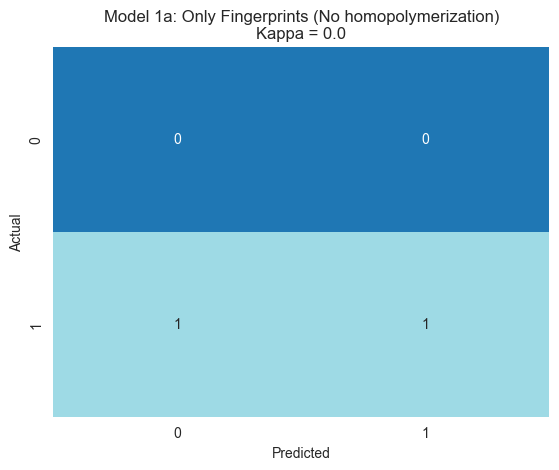

Predict   0         1         
Actual
0         145       0         

1         2         0         





Overall Statistics : 

95% CI                                                            (0.96767,1.00512)
ACC Macro                                                         0.98639
ARI                                                               0.0
AUNP                                                              0.5
AUNU                                                              0.5
Bangdiwala B                                                      0.98639
Bennett S                                                         0.97279
CBA                                                               0.4932
CSI                                                               None
Chi-Squared                                                       None
Chi-Squared DF                                                    1
Conditional Entropy                                               -0.0
C

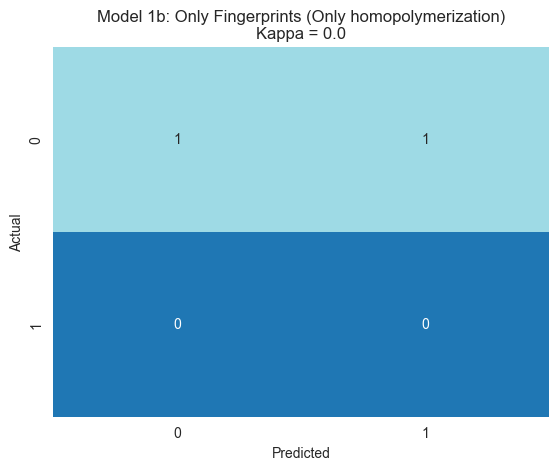

In [15]:
# Model 1a: Training with only the fingerprints of the monomers (full data) for Class 1
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class1_full, test_labels_class1_full, "Model 1a: Only Fingerprints (No homopolymerization)")

# Model 1b: Training with only the fingerprints of the monomers (full data) for Class 2
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class2_full, test_labels_class2_full, "Model 1b: Only Fingerprints (Only homopolymerization)")

Predict   0         1         
Actual
0         16        113       

1         1         17        





Overall Statistics : 

95% CI                                                            (0.15704,0.29194)
ACC Macro                                                         0.22449
ARI                                                               -0.05213
AUNP                                                              0.53424
AUNU                                                              0.53424
Bangdiwala B                                                      0.12023
Bennett S                                                         -0.55102
CBA                                                               0.1274
CSI                                                               0.07021
Chi-Squared                                                       0.7242
Chi-Squared DF                                                    1
Conditional Entropy                                  

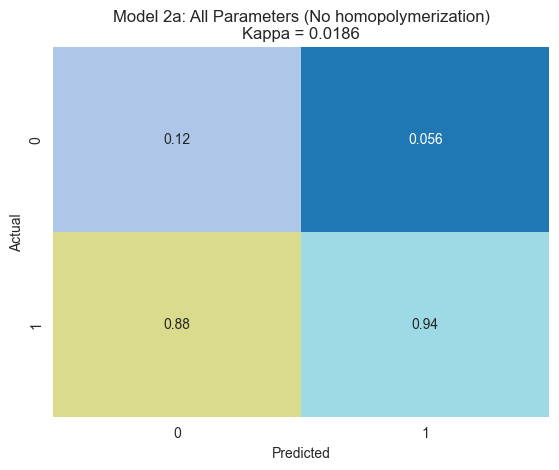

Predict   0         1         
Actual
0         120       25        

1         1         1         





Overall Statistics : 

95% CI                                                            (0.76145,0.88481)
ACC Macro                                                         0.82313
ARI                                                               0.03673
AUNP                                                              0.66379
AUNU                                                              0.66379
Bangdiwala B                                                      0.81838
Bennett S                                                         0.64626
CBA                                                               0.43302
CSI                                                               0.17889
Chi-Squared                                                       1.45415
Chi-Squared DF                                                    1
Conditional Entropy                                  

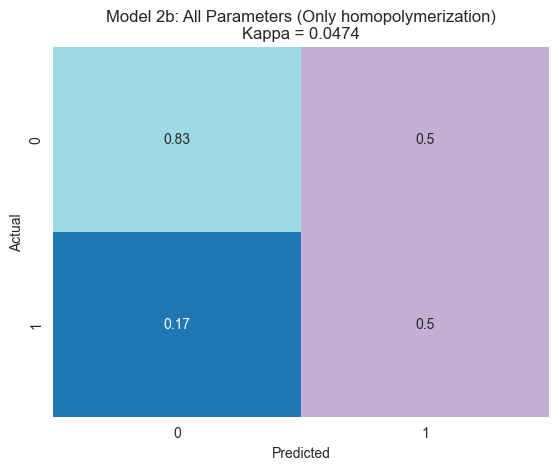

In [16]:
# Model 2a: Training with all parameters (full data) for Class 1
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class1_full, test_labels_class1_full, "Model 2a: All Parameters (No homopolymerization)")

# Model 2b: Training with all parameters (full data) for Class 2
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class2_full, test_labels_class2_full, "Model 2b: All Parameters (Only homopolymerization)")

Predict  0        1        
Actual
0        14       90       

1        1        20       





Overall Statistics : 

95% CI                                                            (0.19399,0.35001)
ACC Macro                                                         0.272
ARI                                                               -0.06541
AUNP                                                              0.5435
AUNU                                                              0.5435
Bangdiwala B                                                      0.15401
Bennett S                                                         -0.456
CBA                                                               0.15822
CSI                                                               0.10107
Chi-Squared                                                       1.25222
Chi-Squared DF                                                    1
Conditional Entropy                                               

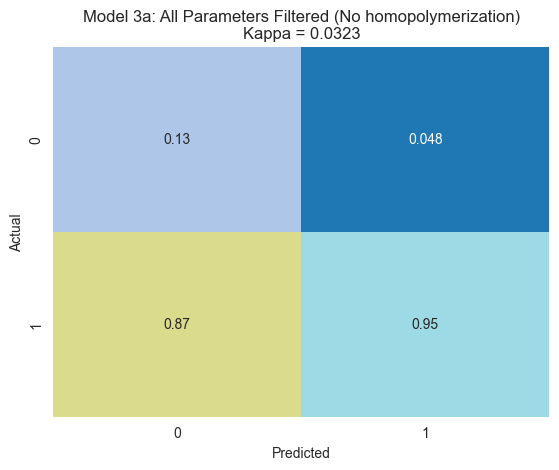

Predict  0        1        
Actual
0        95       29       

1        1        0        





Overall Statistics : 

95% CI                                                            (0.68513,0.83487)
ACC Macro                                                         0.76
ARI                                                               -0.01103
AUNP                                                              0.38306
AUNU                                                              0.38306
Bangdiwala B                                                      0.75631
Bennett S                                                         0.52
CBA                                                               0.38306
CSI                                                               -0.12214
Chi-Squared                                                       0.30452
Chi-Squared DF                                                    1
Conditional Entropy                                               

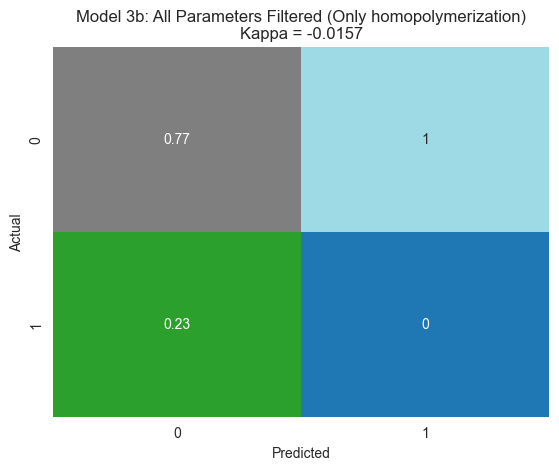

In [17]:
# Model 3a: Training with filtered data (all parameters) for Class 1
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class1_filtered, test_labels_class1_filtered, "Model 3a: All Parameters Filtered (No homopolymerization)")

# Model 3b: Training with filtered data (all parameters) for Class 2
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class2_filtered, test_labels_class2_filtered, "Model 3b: All Parameters Filtered (Only homopolymerization)")

Best hyperparameters for Model 1a: Only Fingerprints (No homopolymerization): {'min_samples_leaf': 20, 'max_leaf_nodes': 31, 'max_iter': 100, 'learning_rate': 0.05, 'class_weight': {0: 1, 1: 50}}
Kappa: 0.000
Best hyperparameters for Model 1b: Only Fingerprints (Only homopolymerization): {'min_samples_leaf': 20, 'max_leaf_nodes': 31, 'max_iter': 100, 'learning_rate': 0.05, 'class_weight': {0: 1, 1: 50}}
Kappa: 0.000
Best hyperparameters for Model 2a: All Parameters (No homopolymerization): {'min_samples_leaf': 10, 'max_leaf_nodes': 15, 'max_iter': 400, 'learning_rate': 0.2, 'class_weight': {0: 1, 1: 50}}
Kappa: 0.029
Best hyperparameters for Model 2b: All Parameters (Only homopolymerization): {'min_samples_leaf': 10, 'max_leaf_nodes': 15, 'max_iter': 200, 'learning_rate': 0.05, 'class_weight': {0: 1, 1: 100}}
Kappa: 0.020
Best hyperparameters for Model 3a: All Parameters Filtered (No homopolymerization): {'min_samples_leaf': 10, 'max_leaf_nodes': 63, 'max_iter': 500, 'learning_rate': 0

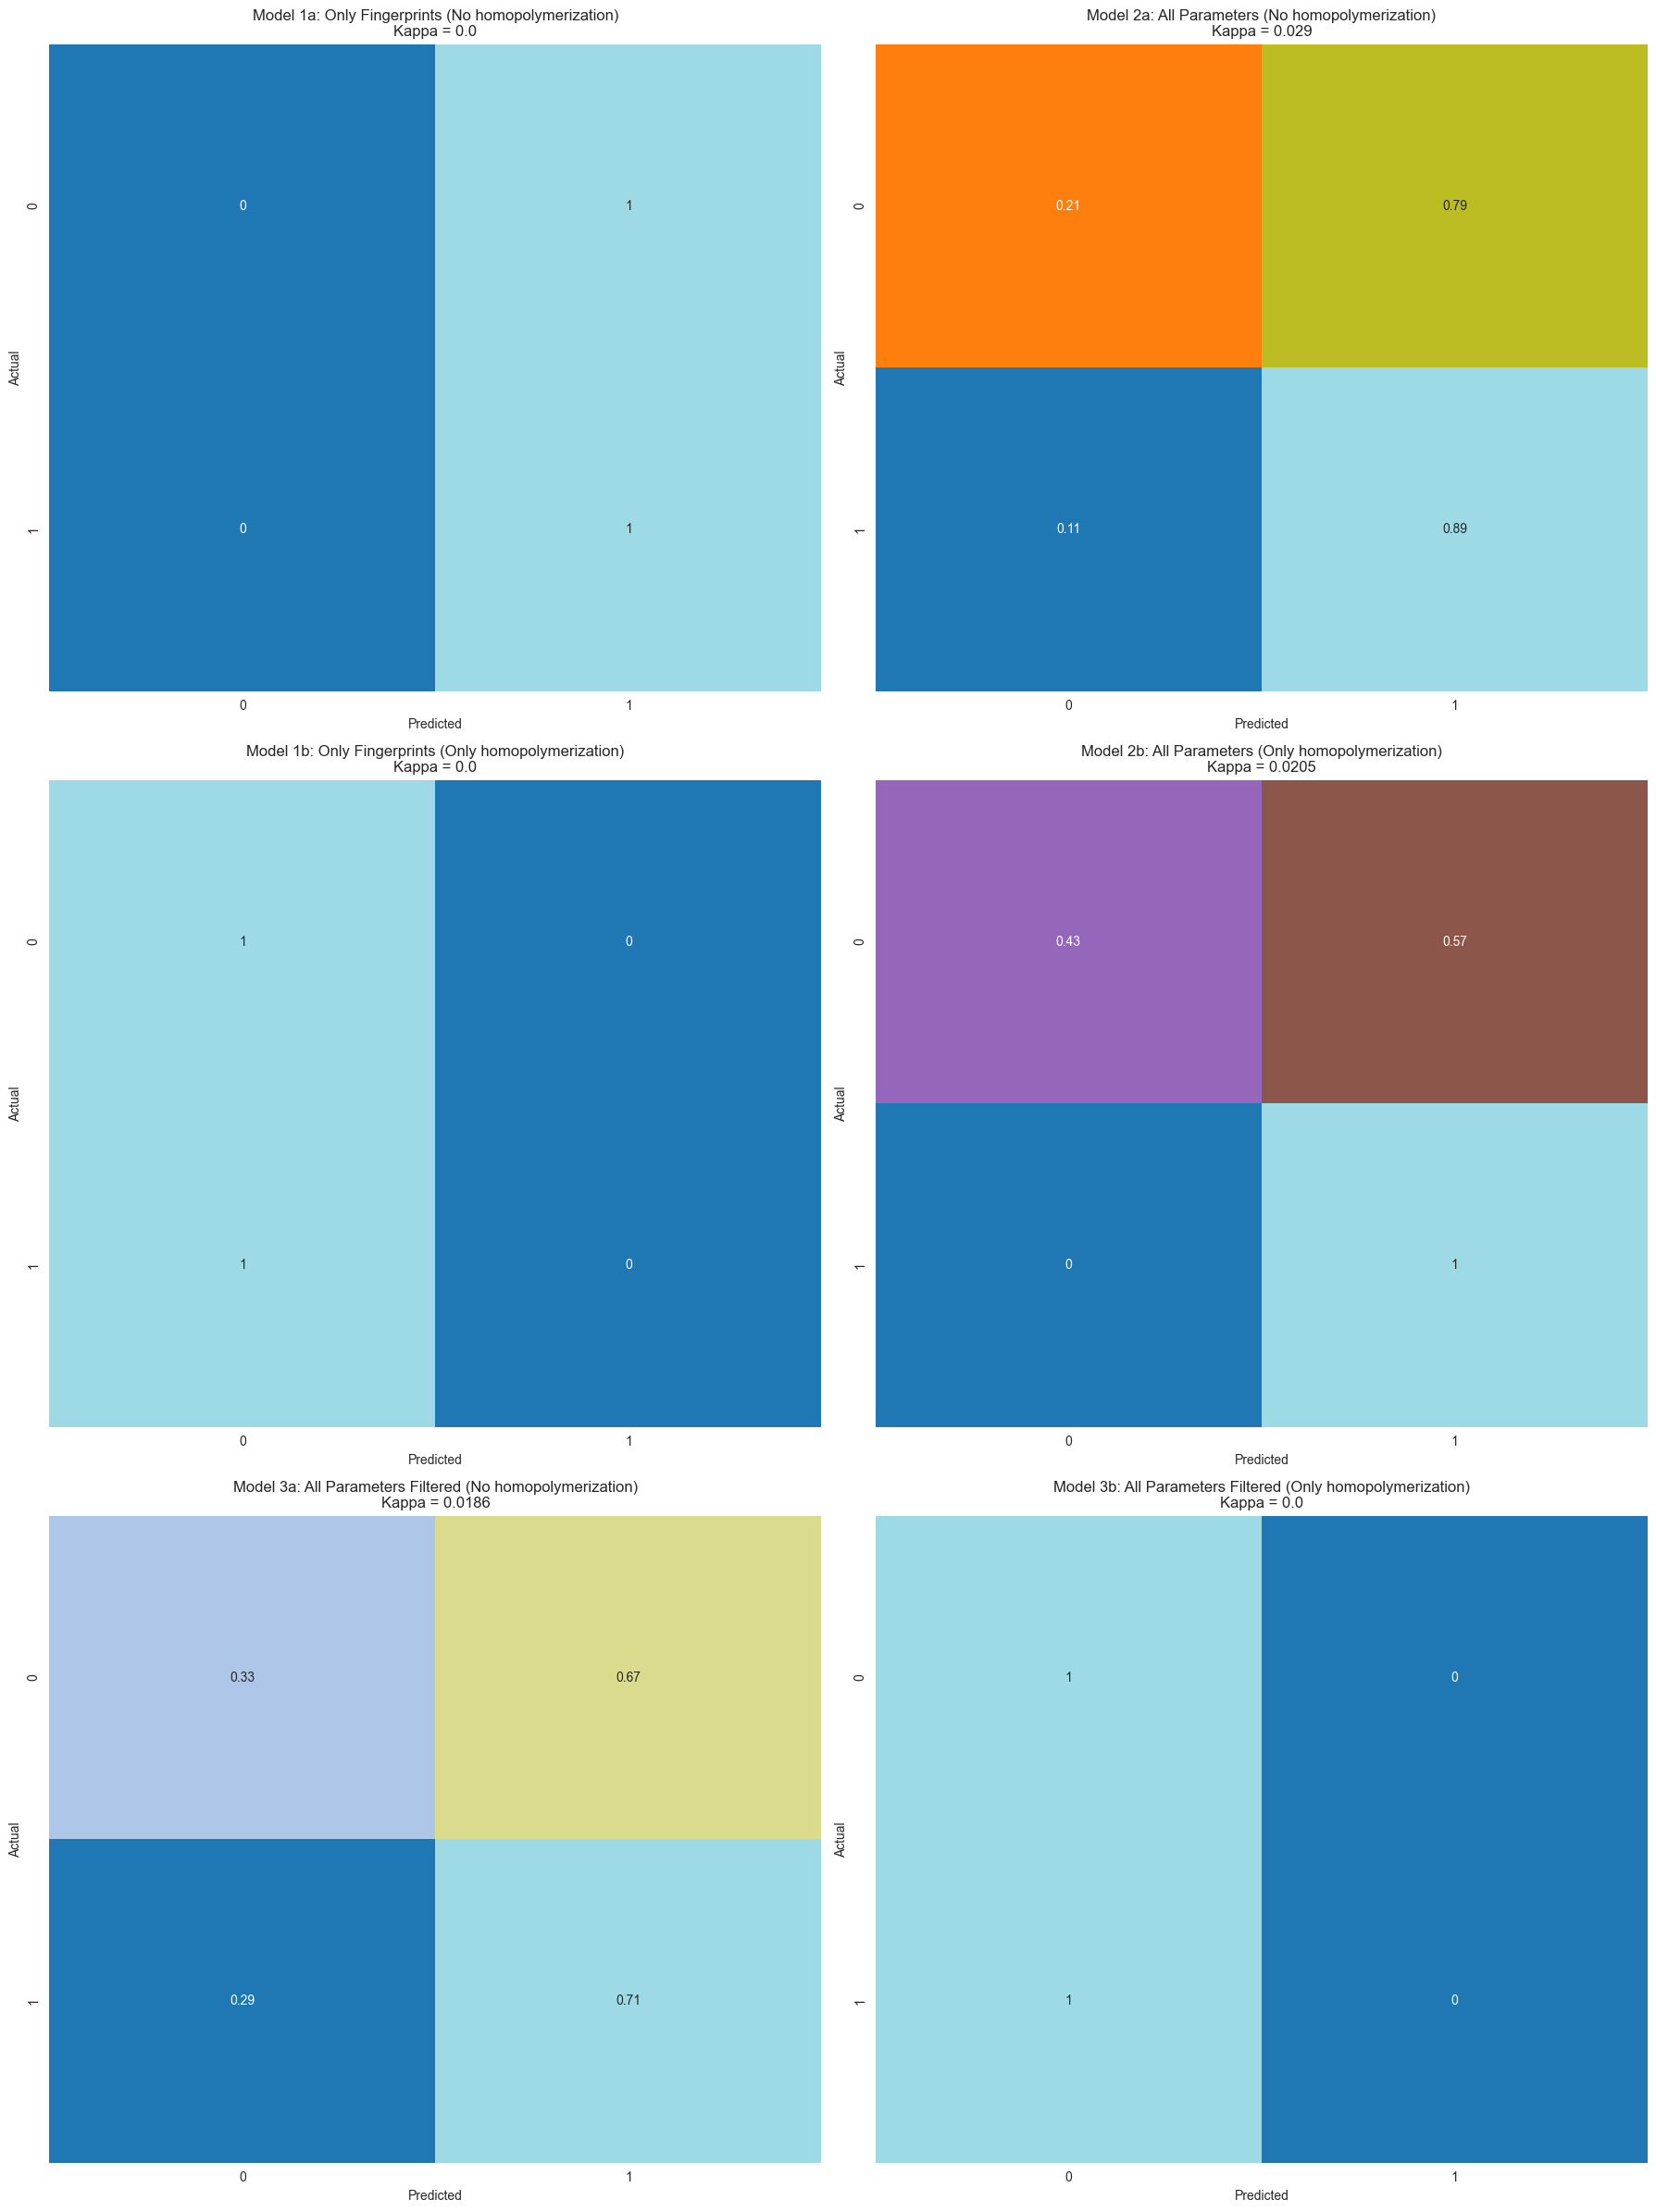

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, cohen_kappa_score, make_scorer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.backends.backend_pdf
import numpy as np

# Function to load data from a JSON file
def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)
    
# Custom scoring function for Cohen's kappa
kappa_scorer = make_scorer(cohen_kappa_score)

# Function to train and evaluate a model and plot confusion matrix in a given subplot
def train_and_evaluate_model(train_features, test_features, train_labels, test_labels, title, ax):
    # Define the parameter grid for RandomizedSearchCV
    param_distributions = {
        'max_iter': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_leaf_nodes': [15, 31, 63],
        'min_samples_leaf': [10, 20, 30],
        'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 50}, {0: 1, 1: 100}]
    }
    
    # Define the base model
    base_model = HistGradientBoostingClassifier(random_state=42)
    
    # Perform RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=50,  # Number of parameter settings sampled
        scoring=kappa_scorer,  # Evaluation metric
        cv=3,  # Number of folds in cross-validation
        random_state=42,
        n_jobs=-1  # Use all available CPUs
    )
    
    search.fit(train_features, train_labels)
    
    # Best model
    best_model = search.best_estimator_
    print(f"Best hyperparameters for {title}: {search.best_params_}")
    
    predictions = best_model.predict(test_features)

    # Evaluate Model
    cm = confusion_matrix(test_labels, predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Calculate Kappa score
    kappa = cohen_kappa_score(test_labels, predictions)
    print(f"Kappa: {kappa:.3f}")

    plt.style.use('../plots_and_figures/custom_colors.mplstyle')
    # Define a custom colormap based on the defined colors
    custom_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Define a colormap for the heatmap
    cmap = sns.color_palette(custom_colors, as_cmap=True)

    # Plot confusion matrix
    sns.heatmap(pd.DataFrame(cm_normalized), annot=True, cmap=cmap, cbar=False, ax=ax)
    ax.set_title(f"{title}\nKappa = {kappa:.3}")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

# Create a PDF to save the plots
pdf = matplotlib.backends.backend_pdf.PdfPages("combined_plots.pdf")

# Create a figure with multiple subplots
fig, axs = plt.subplots(3, 2, figsize=(18, 24))

# Call the function for each model and plot in the corresponding subplot
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class1_full, test_labels_class1_full, "Model 1a: Only Fingerprints (No homopolymerization)", axs[0, 0])
train_and_evaluate_model(train_fingerprints_only_full, test_fingerprints_only_full, train_labels_class2_full, test_labels_class2_full, "Model 1b: Only Fingerprints (Only homopolymerization)", axs[1, 0])
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class1_full, test_labels_class1_full, "Model 2a: All Parameters (No homopolymerization)", axs[0, 1])
train_and_evaluate_model(train_all_features_full, test_all_features_full, train_labels_class2_full, test_labels_class2_full, "Model 2b: All Parameters (Only homopolymerization)", axs[1, 1])
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class1_filtered, test_labels_class1_filtered, "Model 3a: All Parameters Filtered (No homopolymerization)", axs[2, 0])
train_and_evaluate_model(train_all_features_filtered, test_all_features_filtered, train_labels_class2_filtered, test_labels_class2_filtered, "Model 3b: All Parameters Filtered (Only homopolymerization)", axs[2, 1])

# Adjust layout
plt.tight_layout()

# Save the figure to the PDF
pdf.savefig(fig)

# Close the PDF
pdf.close()

# Show the combined plot
plt.show()